<h1><center>Robustness - MNIST</center></h1>

In [56]:
#Import libraries and helper methods

import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm.notebook import tqdm
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, DBSCAN, Birch
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn import metrics

from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.metrics import f1_score
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def pick(results, train_ratio=None, reduction_train=None, reduction_test=None, model=None):
    tmp = results
    if(train_ratio != None):
        tmp = tmp[(tmp.index.get_level_values('train_ratio') == train_ratio)]
    if(reduction_test != None):
        tmp = tmp[(tmp.index.get_level_values('reduction_test') == reduction_test)]
    if(model != None):
        tmp = tmp.loc[model]
    return tmp

def compute_lip(model, results, lipschitz, train_ratio, reduction_train=None, reduction_test=None):
    test_f1 = pick(results, train_ratio=train_ratio, reduction_train=reduction_train,  reduction_test=reduction_test, model=model).values
    final_results = []
    for i in range(len(test_f1)):
        elem_i = test_f1[i]
        for j in range(i+1, len(test_f1)):
            elem_j = test_f1[j]
            if(lipschitz):
                lipschitz_cte_estimator = (abs(elem_j-elem_i)/abs(j-i))
                final_results.append((j-i, lipschitz_cte_estimator))
            else:
                final_results.append(((j-i), (elem_j-elem_i)**2))
    final_results.sort(key=lambda tup: tup[0])  # sorts in place
    return final_results, np.mean([x[1] for x in final_results])
    
def plot_distance_performance(model,l, ax, marker):
    d = defaultdict(list)
    distance_performance = []
    for key, value in l:
        d[key].append(value)

    for key in d:
        distance_performance.append((key, np.mean(d[key])))

    ax.scatter(*zip(*distance_performance), label=model, marker=marker, s=50, alpha=0.8)

In [57]:
unsupervised_models = ['KMeans', 'Birch', 'IsolationForest', 'GaussianMixture', 'LocalOutlierFactor']
supervised_models = ['SVC', 'LogisticRegression', 'DecisionTreeClassifier', 'AdaBoostClassifier']
random_models = ['random_zeros', 'random_ones', 'random_half_half', 'random_anomaly_perc']

## (Un)Supervised

In [58]:
results = []

In [ ]:
for train_ratio in [0.5, 0.75, 0.9]:
    print('Training ratio ', train_ratio)
    for i in range(10):
        (xtrain, ytrain), (xtest, ytest) = mnist.load_data()
        X = np.concatenate((xtrain, xtest)).reshape(-1, 784).astype(np.float64)
        y = np.concatenate((ytrain, ytest)).astype(np.int64)
        
        #Limit number of samples for fast computation
        N_SAMPLES = 50000
        X = X[:N_SAMPLES]
        y = y[:N_SAMPLES]
        
        single = i
        
        np.put(y, np.argwhere(y == single), -1)
        np.put(y, np.argwhere(y != -1), 0)
        np.put(y, np.argwhere(y == -1), 1)
        
        X_train, X_test, y_train , y_test = train_test_split(X, y, train_size=train_ratio)

        #Supervised
        lr = LogisticRegression()
        dt = DecisionTreeClassifier()
        ada = AdaBoostClassifier()
        svm = SVC()

        #Unsupervised
        kmeans = KMeans(2)
        birch = Birch(n_clusters=2)
        iso_forest = IsolationForest()
        lof = LocalOutlierFactor(novelty=True)
        gmm = GaussianMixture()
        
        ros = RandomOverSampler()
        X_res, y_res = ros.fit_resample(X_train, y_train)
        
        for model in [dt, ada, svm, lr]:
            model.fit(X_res, y_res)
            
        for model in [kmeans, birch, iso_forest, lof, gmm]:
            model.fit(X_train)

        for reduc_perc in [0, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]:
            normal_index = np.argwhere(y_test == 0).flatten()
            abnormal_index = np.argwhere(y_test == 1).flatten()

            normal = y_test[normal_index]

            reduced_abnormal_index = np.random.choice(abnormal_index, int(len(abnormal_index) * (1-reduc_perc)))
            reduced_abnormal = y_test[reduced_abnormal_index]

            reduced_x = np.concatenate((X_test[normal_index], X_test[reduced_abnormal_index]))
            reduced_labels = np.concatenate((normal, reduced_abnormal))  

            for model in [dt, ada, svm, kmeans, birch, lr, iso_forest, lof, gmm]:        
                y_predict = model.predict(reduced_x)

                if(type(model).__name__ in ['IsolationForest', 'LocalOutlierFactor']):
                    y_predict = (y_predict < 0).astype(int)
                    
                f_score = f1_score(reduced_labels, y_predict)
                results.append((type(model).__name__, train_ratio, i, reduc_perc, f_score))

## Baselines

In [ ]:
for train_ratio in [0.5, 0.75, 0.9]:
    for i in range(10):
        (xtrain, ytrain), (xtest, ytest) = mnist.load_data()
        X = np.concatenate((xtrain, xtest)).reshape(-1, 784).astype(np.float64)
        y = np.concatenate((ytrain, ytest)).astype(np.int64)
        
        N_SAMPLES = 50000
        X = X[:N_SAMPLES]
        y = y[:N_SAMPLES]
        
        single = i
        
        np.put(y, np.argwhere(y == single), -1)
        np.put(y, np.argwhere(y != -1), 0)
        np.put(y, np.argwhere(y == -1), 1)
        
        X_train, X_test, y_train , y_test = train_test_split(X, y, train_size=train_ratio)

        for reduc_perc in [0, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]:
            normal_index = np.argwhere(y_test == 0).flatten()
            abnormal_index = np.argwhere(y_test == 1).flatten()

            normal = y_test[normal_index]

            reduced_abnormal_index = np.random.choice(abnormal_index, int(len(abnormal_index) * (1-reduc_perc)))
            reduced_abnormal = y_test[reduced_abnormal_index]

            reduced_x = np.concatenate((X_test[normal_index], X_test[reduced_abnormal_index]))
            reduced_labels = np.concatenate((normal, reduced_abnormal))  

            anomaly_percs = [0, 1, 0.5, sum(y_train)/len(y_train)]
            random_names = ['random_zeros', 'random_ones', 'random_half_half','random_anomaly_perc']
            for anomaly_perc, model_name in list(zip(anomaly_percs, random_names)):
                y_predict = np.random.choice([0, 1], size=(len(reduced_labels),), p=[1-anomaly_perc, anomaly_perc])
                f_score = f1_score(reduced_labels, y_predict)
                results.append((model_name, train_ratio, i, reduc_perc, f_score))

In [63]:
full_df = pd.DataFrame(results, columns=['model', 'train_ratio', 'single', 'reduction_test', 'f_score'])
full_df_grouped = full_df.groupby(['model', 'train_ratio', 'reduction_test']).agg(np.mean)[['f_score']]

In [54]:
#Save data frame
full_df_grouped.to_csv('Robustness-MNIST.csv')

In [64]:
reduction_train= 0
lipschitz = True
training_ratios = [0.5, 0.75, 0.9]
lipschitz_per_model = []

for training_ratio in training_ratios:
    for model in set(full_df.model):
        l, mean_lip = compute_lip(model, full_df_grouped, lipschitz, training_ratio, reduction_train)
        lipschitz_per_model.append((model, training_ratio, mean_lip))

## Plot average robustness 

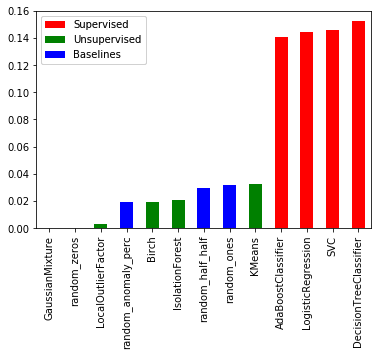

In [65]:
fig, ax = plt.subplots()

robustness_df = pd.DataFrame(lipschitz_per_model, columns=['Model', 'train_ratio', 'lipschitz'])
robustness_df_grouped = robustness_df.groupby(['Model']).agg(np.mean)['lipschitz'].sort_values()
color_code = ['r' if x in supervised_models else 'g' if (x in unsupervised_models) else 'b' for x in robustness_df_grouped.index]

robustness_df_grouped.plot.bar(color=color_code)

legend_elements = [Patch(facecolor='r',label='Supervised'),
                   Patch(facecolor='g',label='Unsupervised'),
                  Patch(facecolor='b', label='Baselines')]

legend = ax.legend(handles=legend_elements, loc=2)
ax.add_artist(legend)
plt.xlabel('')
plt.savefig('Robustness_MNIST.eps', bbox_inches='tight', format='eps')

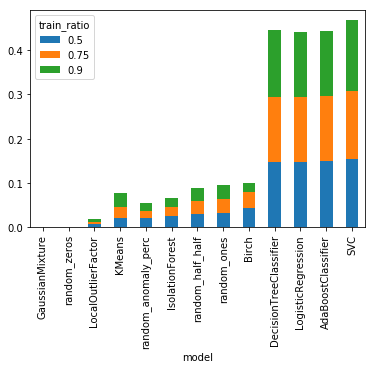

In [43]:
lip_df = pd.DataFrame(lipschitz_per_model, columns=['model', 'train_ratio', 'robustness'])
lip_df.pivot(index='model', columns='train_ratio', values='robustness').sort_values(by=0.5).plot(kind='bar', stacked=True)

## Plot robustness by training ratio

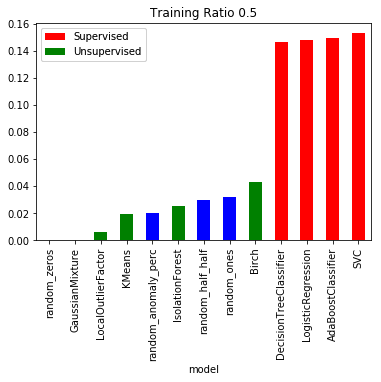

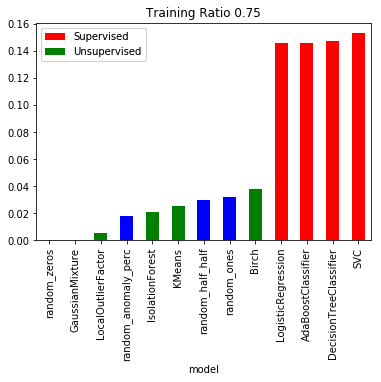

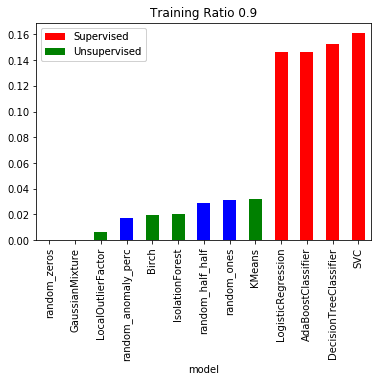

In [66]:
for train_ratio in [0.5, 0.75, 0.9]:
    fig, ax = plt.subplots()
    sorted_lip = lip_df[lip_df.train_ratio == train_ratio].set_index('model')['robustness'].sort_values()
    color_code = ['r' if x in supervised_models else 'g' if (x in unsupervised_models) else 'b' for x in sorted_lip.index]

    sorted_lip.plot.bar(color=color_code)
    plt.title('Training Ratio ' + str(train_ratio))
    
    legend_elements = [Patch(facecolor='r',label='Supervised'),
                       Patch(facecolor='g',label='Unsupervised')]

    legend = ax.legend(handles=legend_elements, loc=2)
    ax.add_artist(legend)